In [1]:
# Import python packages
import bone_fight as bf
import tangram as tg
from anndata import AnnData
import sys, os
sys.path.insert(0, "FISHscale")
from FISHscale.utils import dataset
import scanpy as sc
sc.settings.verbosity = 0
sc.set_figure_params(dpi = 450, dpi_save = 450)
import numpy as np
from scipy.spatial.distance import pdist
from scipy.spatial import KDTree
from sklearn.preprocessing import scale
import fastcluster
import scipy.cluster.hierarchy as hc
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb, hex2color
import pandas as pd

# Set plotting settings
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = "none"
mpl.rcParams['legend.labelcolor'] = "black"
mpl.rcParams['text.color'] = "black"

if not os.path.exists('figures'):
   os.makedirs('figures')

INFO:root:Could not import Cellpose. Ignore if cell segmentation is not needed. Error: No module named 'cellpose'


Geopandas not installed. Install if desired. Error: No module named 'geopandas'
Geopandas not installed. Install if desired. Error: No module named 'geopandas'


# Read and process spatial data

In [2]:
# Read spatial data
d = dataset.Dataset("Data/LBEXP20211113_EEL_HE_5w_970um_RNA_transformed_assigned.parquet",
                       gene_label = 'decoded_genes', 
                       x_label = 'r_transformed', 
                       y_label = 'c_transformed', 
                       pixel_size='0.27 micrometer', 
                       other_columns=['Brain'],
                       z = 970,
                       reparse=False)
d.set_working_selection("Brain")

INFO:root:    Loaded: LBEXP20211113_EEL_HE_5w_970um_RNA_transformed_assigned
INFO:root:    Working selection set to: Brain


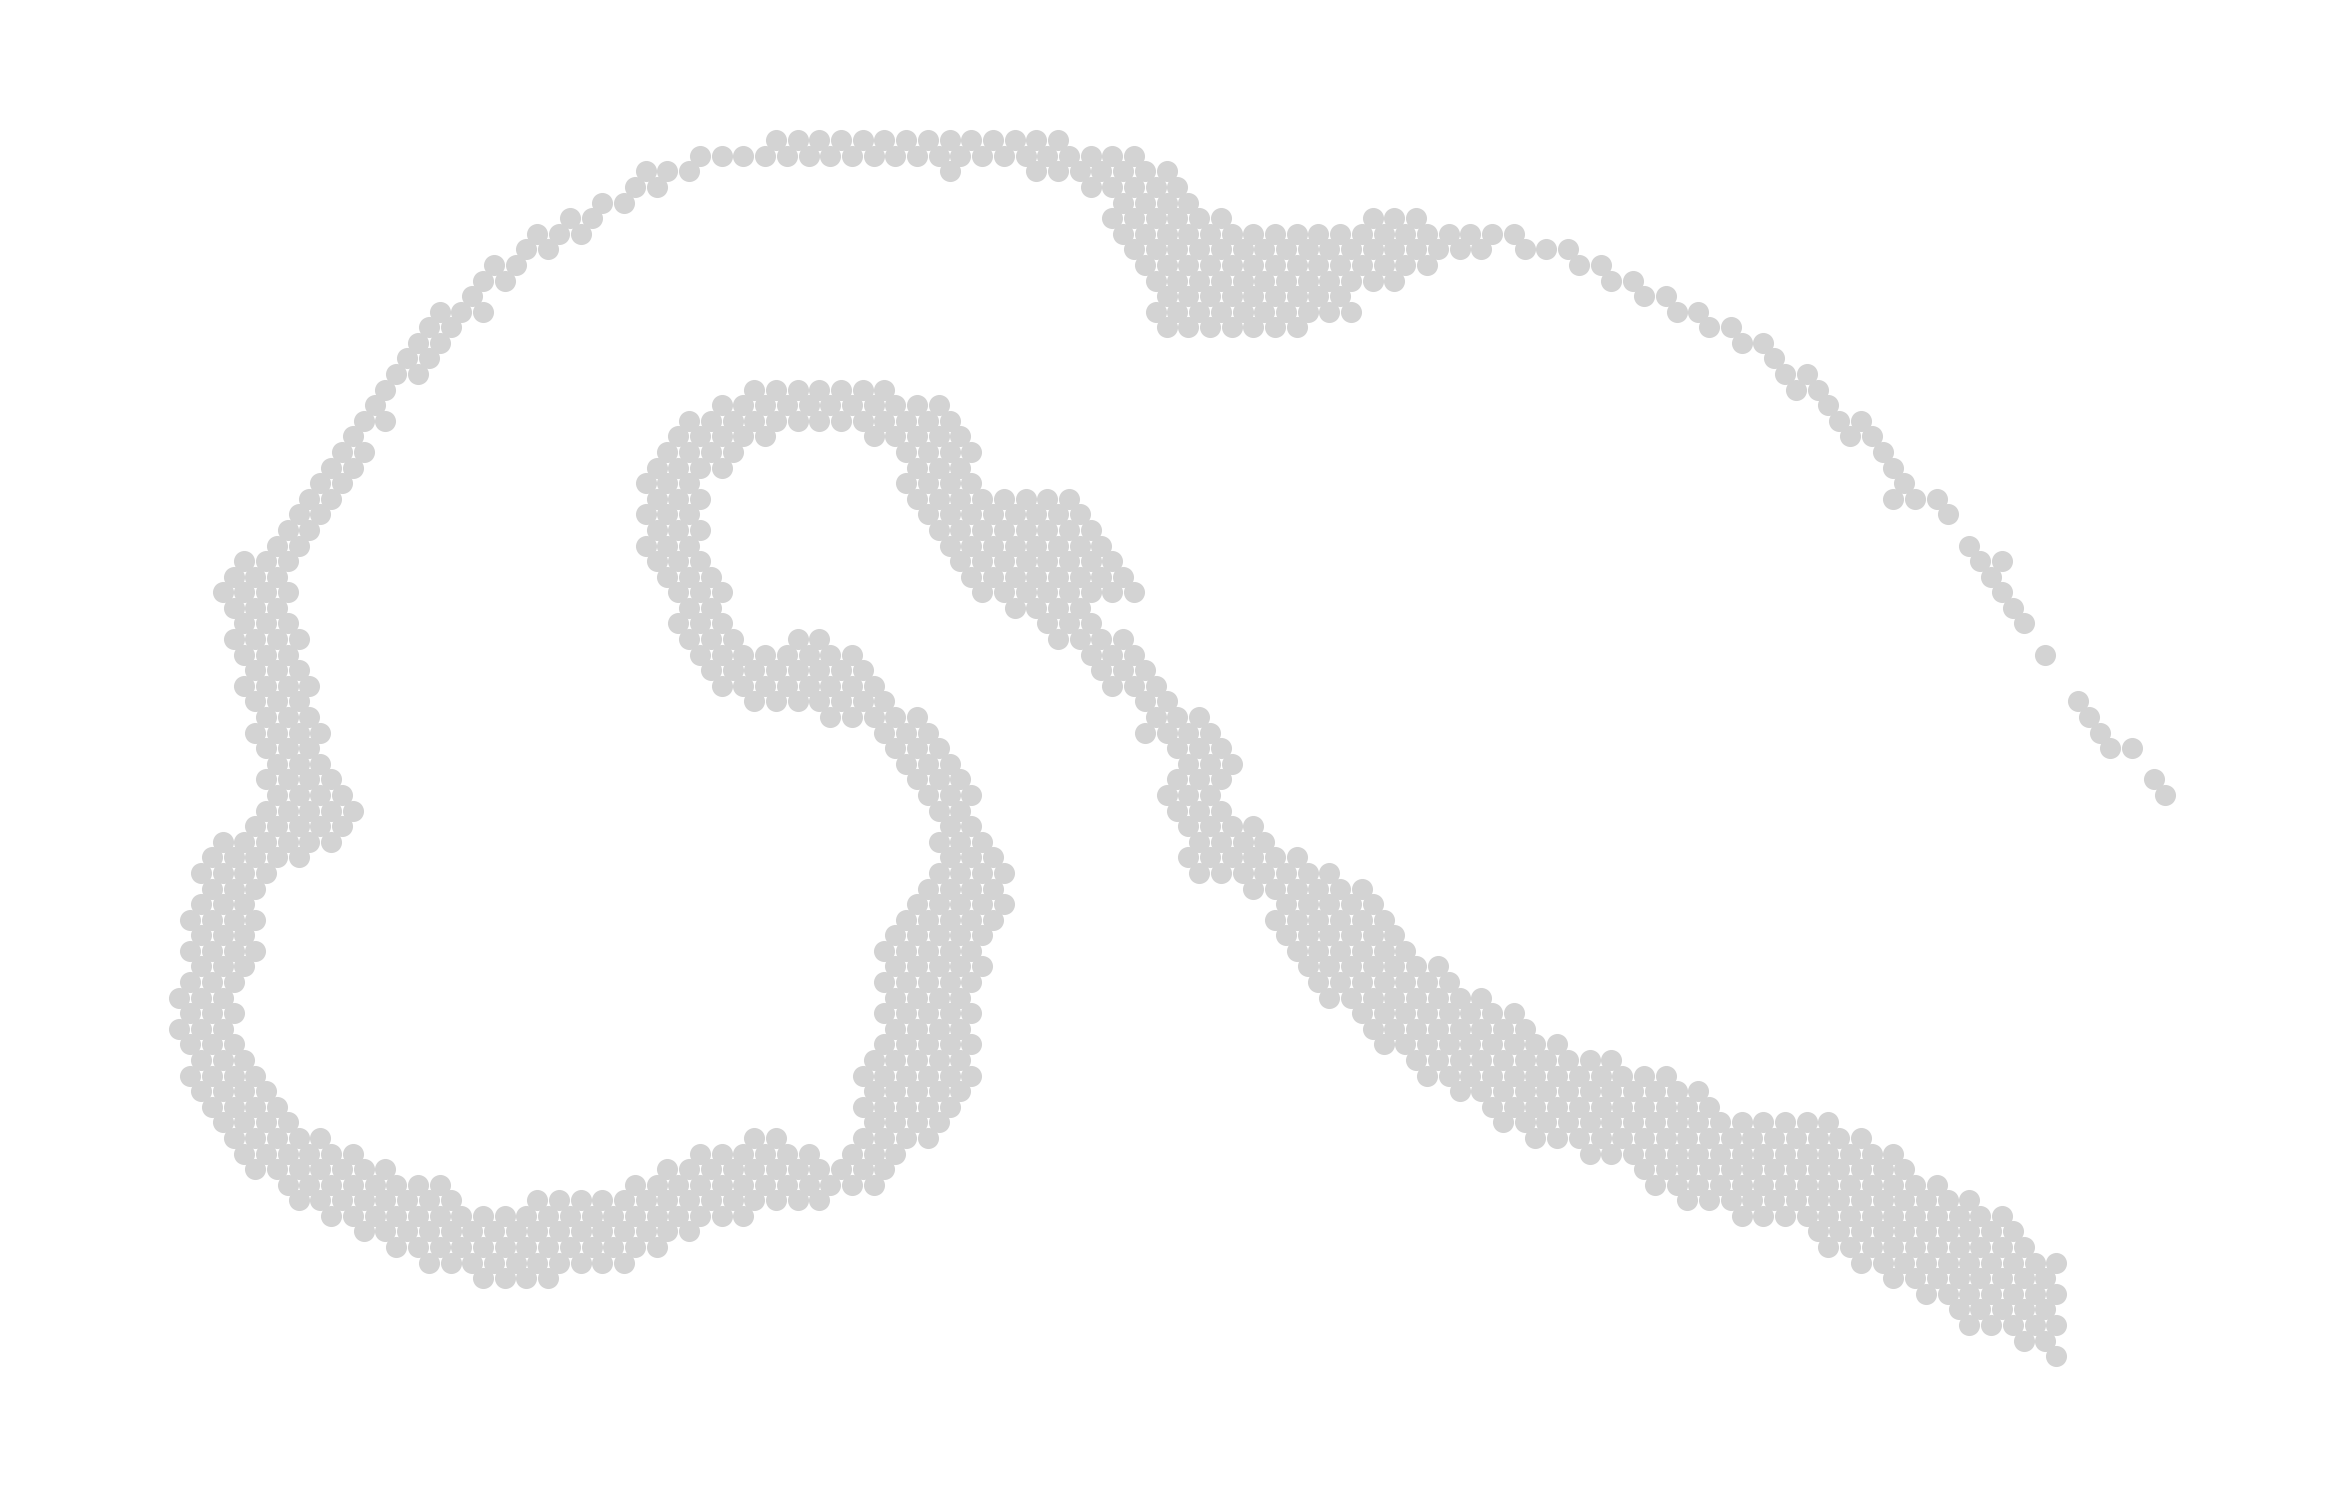

In [3]:
# Creating AnnData object from fishscale spatial data

# Make hexagonal bins, the output can be used to create adata object
# Returns pandas count dataframe to df_hex and spatial coordinates (x, y) to a list variable
df_hex, coordinates = d.hexbin_make(spacing=50, min_count=10)

# Initialize variables
coordinates_to_keep = []
count_df = df_hex.T
spots_to_remove = []
x, y = [], []

# The spatial data contains part (hindbrain) which doesn't occur in our mistr data 
# Using the spatial coordinates (x, y) we are able to select the spots we are interested in 
for i, spot in enumerate(count_df.index):
    if coordinates[i][0] < 1800 and coordinates[i][1] < 4300:
        spots_to_remove.append(spot)
    else:
        coordinates_to_keep.append([coordinates[i][0]*-1,coordinates[i][1]])
        x.append(coordinates[i][0]*-1)
        y.append(coordinates[i][1])

# Remove the unnecessary rows from df based on the spots_to_remove index list
count_df = count_df.drop(spots_to_remove)

# Create volume vector for bonefight
volume_sp = np.array([1] * len(count_df))

# Initialize anndata with count data, and add the spatial cordinates 
adata_spatial = AnnData(count_df.to_numpy(), obsm={"spatial": np.array(coordinates_to_keep)})
adata_spatial.var.index = np.array(count_df.columns)
adata_spatial.obs.index = np.array(count_df.index)
adata_spatial.obs["x"] = x
adata_spatial.obs["y"] = y

# Plot results after removing the parts not occuring in our single cell data
with plt.rc_context({"figure.figsize": [3.5, 2.2],   "figure.dpi": 400}):
    xs = adata_spatial.obs.x.values
    ys = adata_spatial.obs.y.values
    plt.axis("off")
    plt.scatter(xs, ys, s=0.8, color="#D3D3D3");
    plt.savefig("figures/raw_spatial_data.png", dpi=450, bbox_inches='tight')
    plt.savefig("figures/raw_spatial_data.svg", dpi=450, bbox_inches='tight')

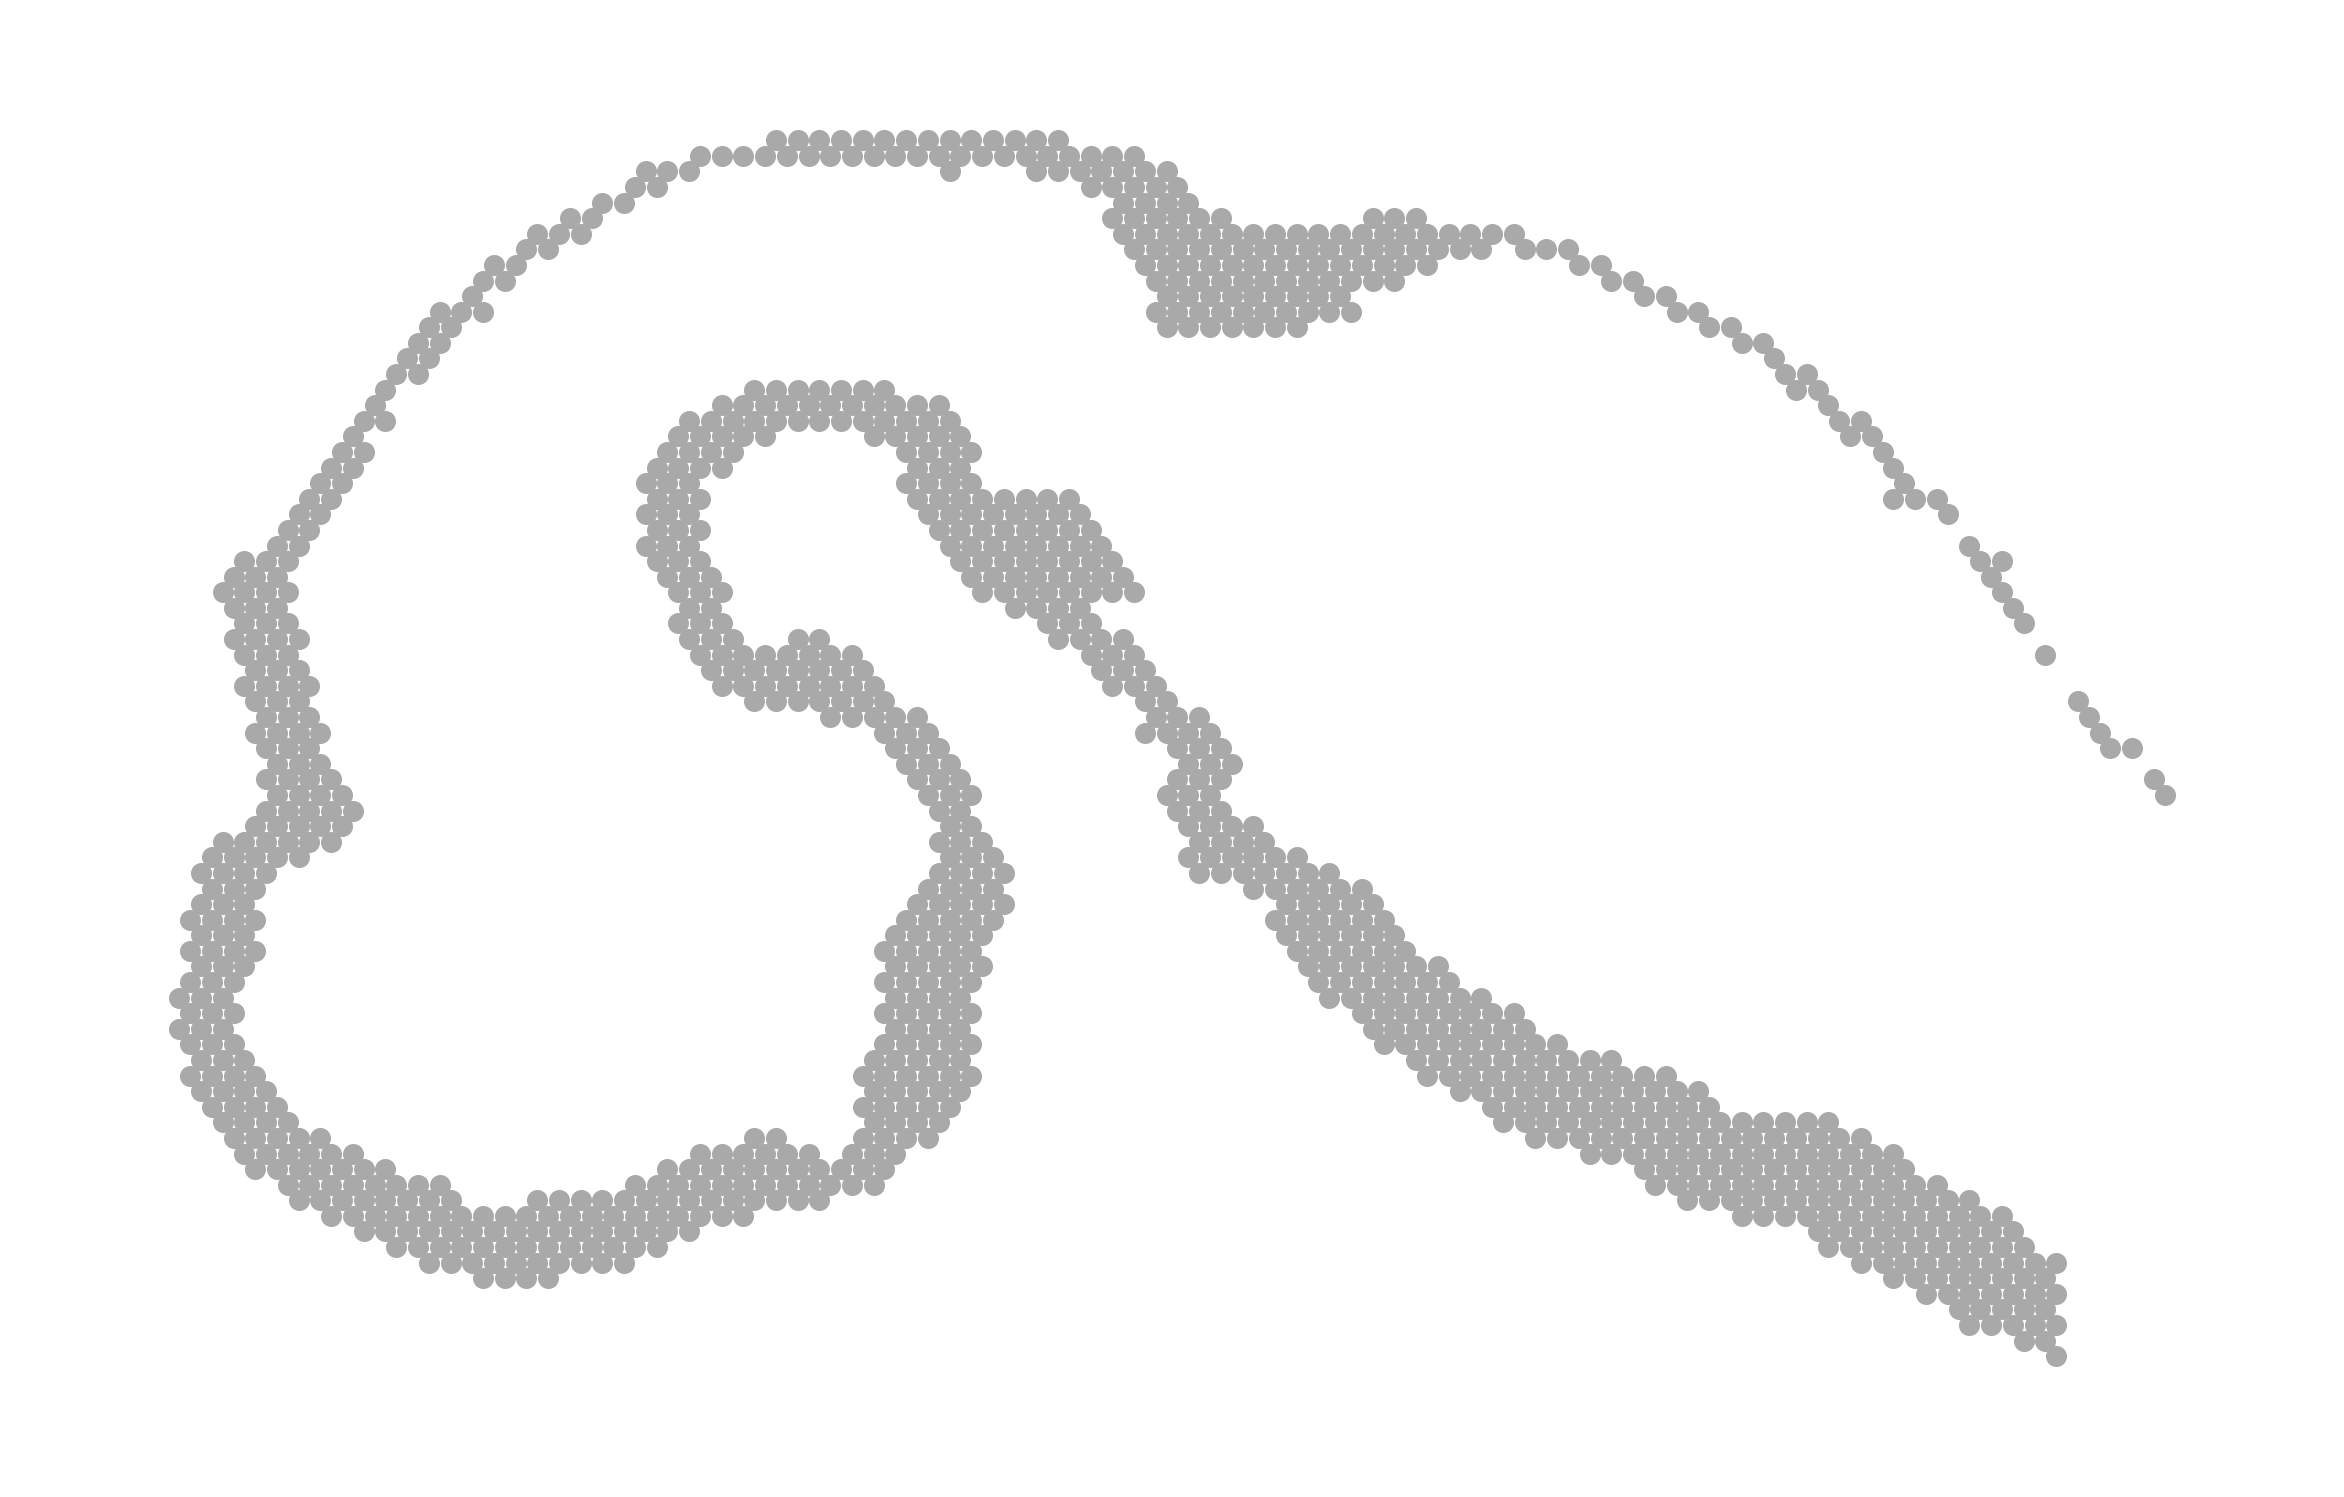

In [4]:
# Plot results after removing the parts not occuring in our single cell data
with plt.rc_context({"figure.figsize": [3.5, 2.2],   "figure.dpi": 400}):
    xs = adata_spatial.obs.x.values
    ys = adata_spatial.obs.y.values
    plt.axis("off")
    plt.scatter(xs, ys, s=0.8, color="#A9A9A9");
    plt.savefig("figures/raw_spatial_data_2.png", dpi=450, bbox_inches='tight')
    plt.savefig("figures/raw_spatial_data_2.svg", dpi=450, bbox_inches='tight')

# Read single cell data and prepare the data for bonefight

In [5]:
# Reading and plotting MiSTR data
mistr_data = sc.read_h5ad('/scratch/datasets/mistr/all_mistr_mnn.h5ad')

Number of training genes for BoneFight:  125


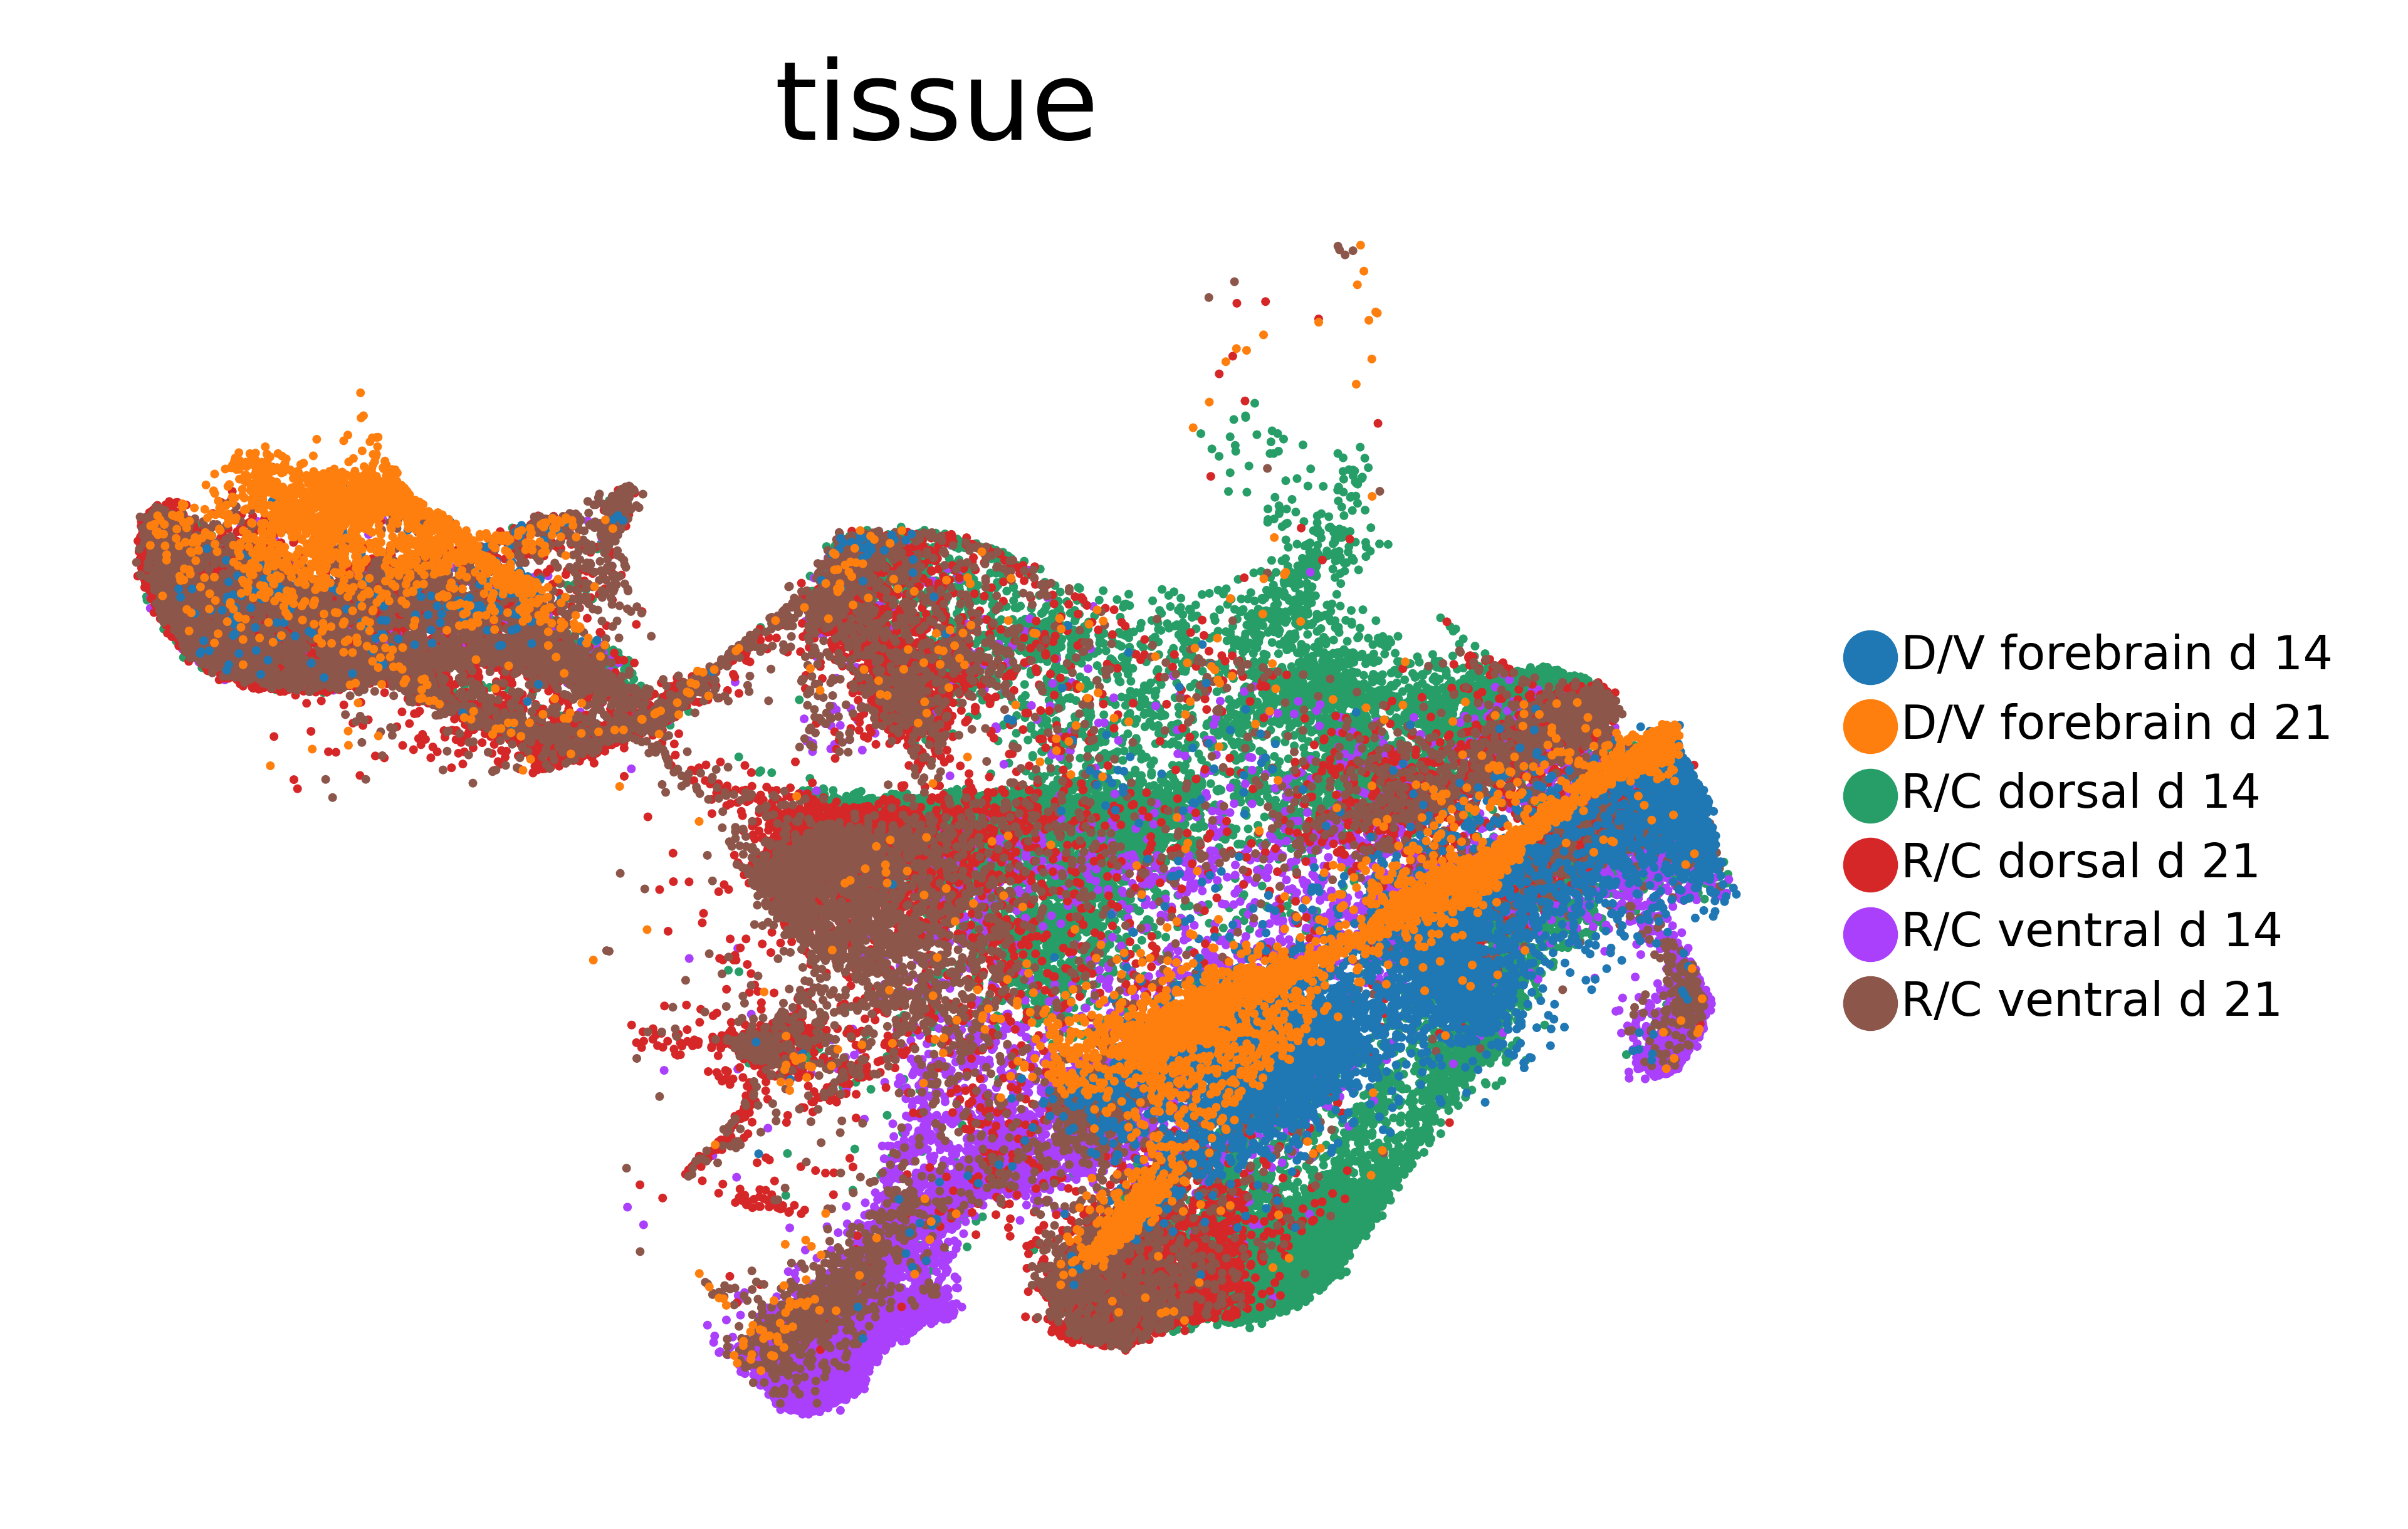

In [6]:
# Store spatial data before subsetting it
adata_spatial_full = adata_spatial.copy()

# Extract d14 and d21 data from the single cell data
mistr_data_d14_d21 = mistr_data[mistr_data.obs["day"].isin(["day 14", "day 21"])]

# Subset our mistr data using genes that are shared with the spatial data
common_genes = [gene for gene in mistr_data_d14_d21.var.index if gene in adata_spatial.var.index]
mistr_data_d14_d21_gene_subset = mistr_data_d14_d21[:, common_genes]

# We run bonefight using only DE genes 
# From each cluster (6 tissues), we select 25 DE genes, leading to 125 genes
sc.tl.rank_genes_groups(mistr_data_d14_d21_gene_subset, groupby="tissue", use_raw=False )
genes_to_keep_df = pd.DataFrame(mistr_data_d14_d21_gene_subset.uns["rank_genes_groups"]["names"]).iloc[0:25, :]
genes_to_keep = list(np.unique(genes_to_keep_df.melt().value.values))

print("Number of training genes for BoneFight: ", len(genes_to_keep))

# Subset the data using identified DE genes
mistr_data_d14_d21_gene_subset_2 = mistr_data_d14_d21_gene_subset[:, genes_to_keep]
adata_spatial = adata_spatial[:, genes_to_keep]
count_df = count_df[count_df.columns[count_df.columns.isin(genes_to_keep)]]

# Plot d14 and d21 single cell data
with plt.rc_context({"figure.figsize": [4, 3],  "figure.dpi": 450}):
    sc.pl.umap(mistr_data_d14_d21, color="tissue", size = 5, frameon=False,legend_fontsize = 6, save="_mistr_d14_d21.svg")
    sc.pl.umap(mistr_data_d14_d21, color="tissue", size = 5, frameon=False, show=False, legend_fontsize = 6, save="_mistr_d14_d21.png")    

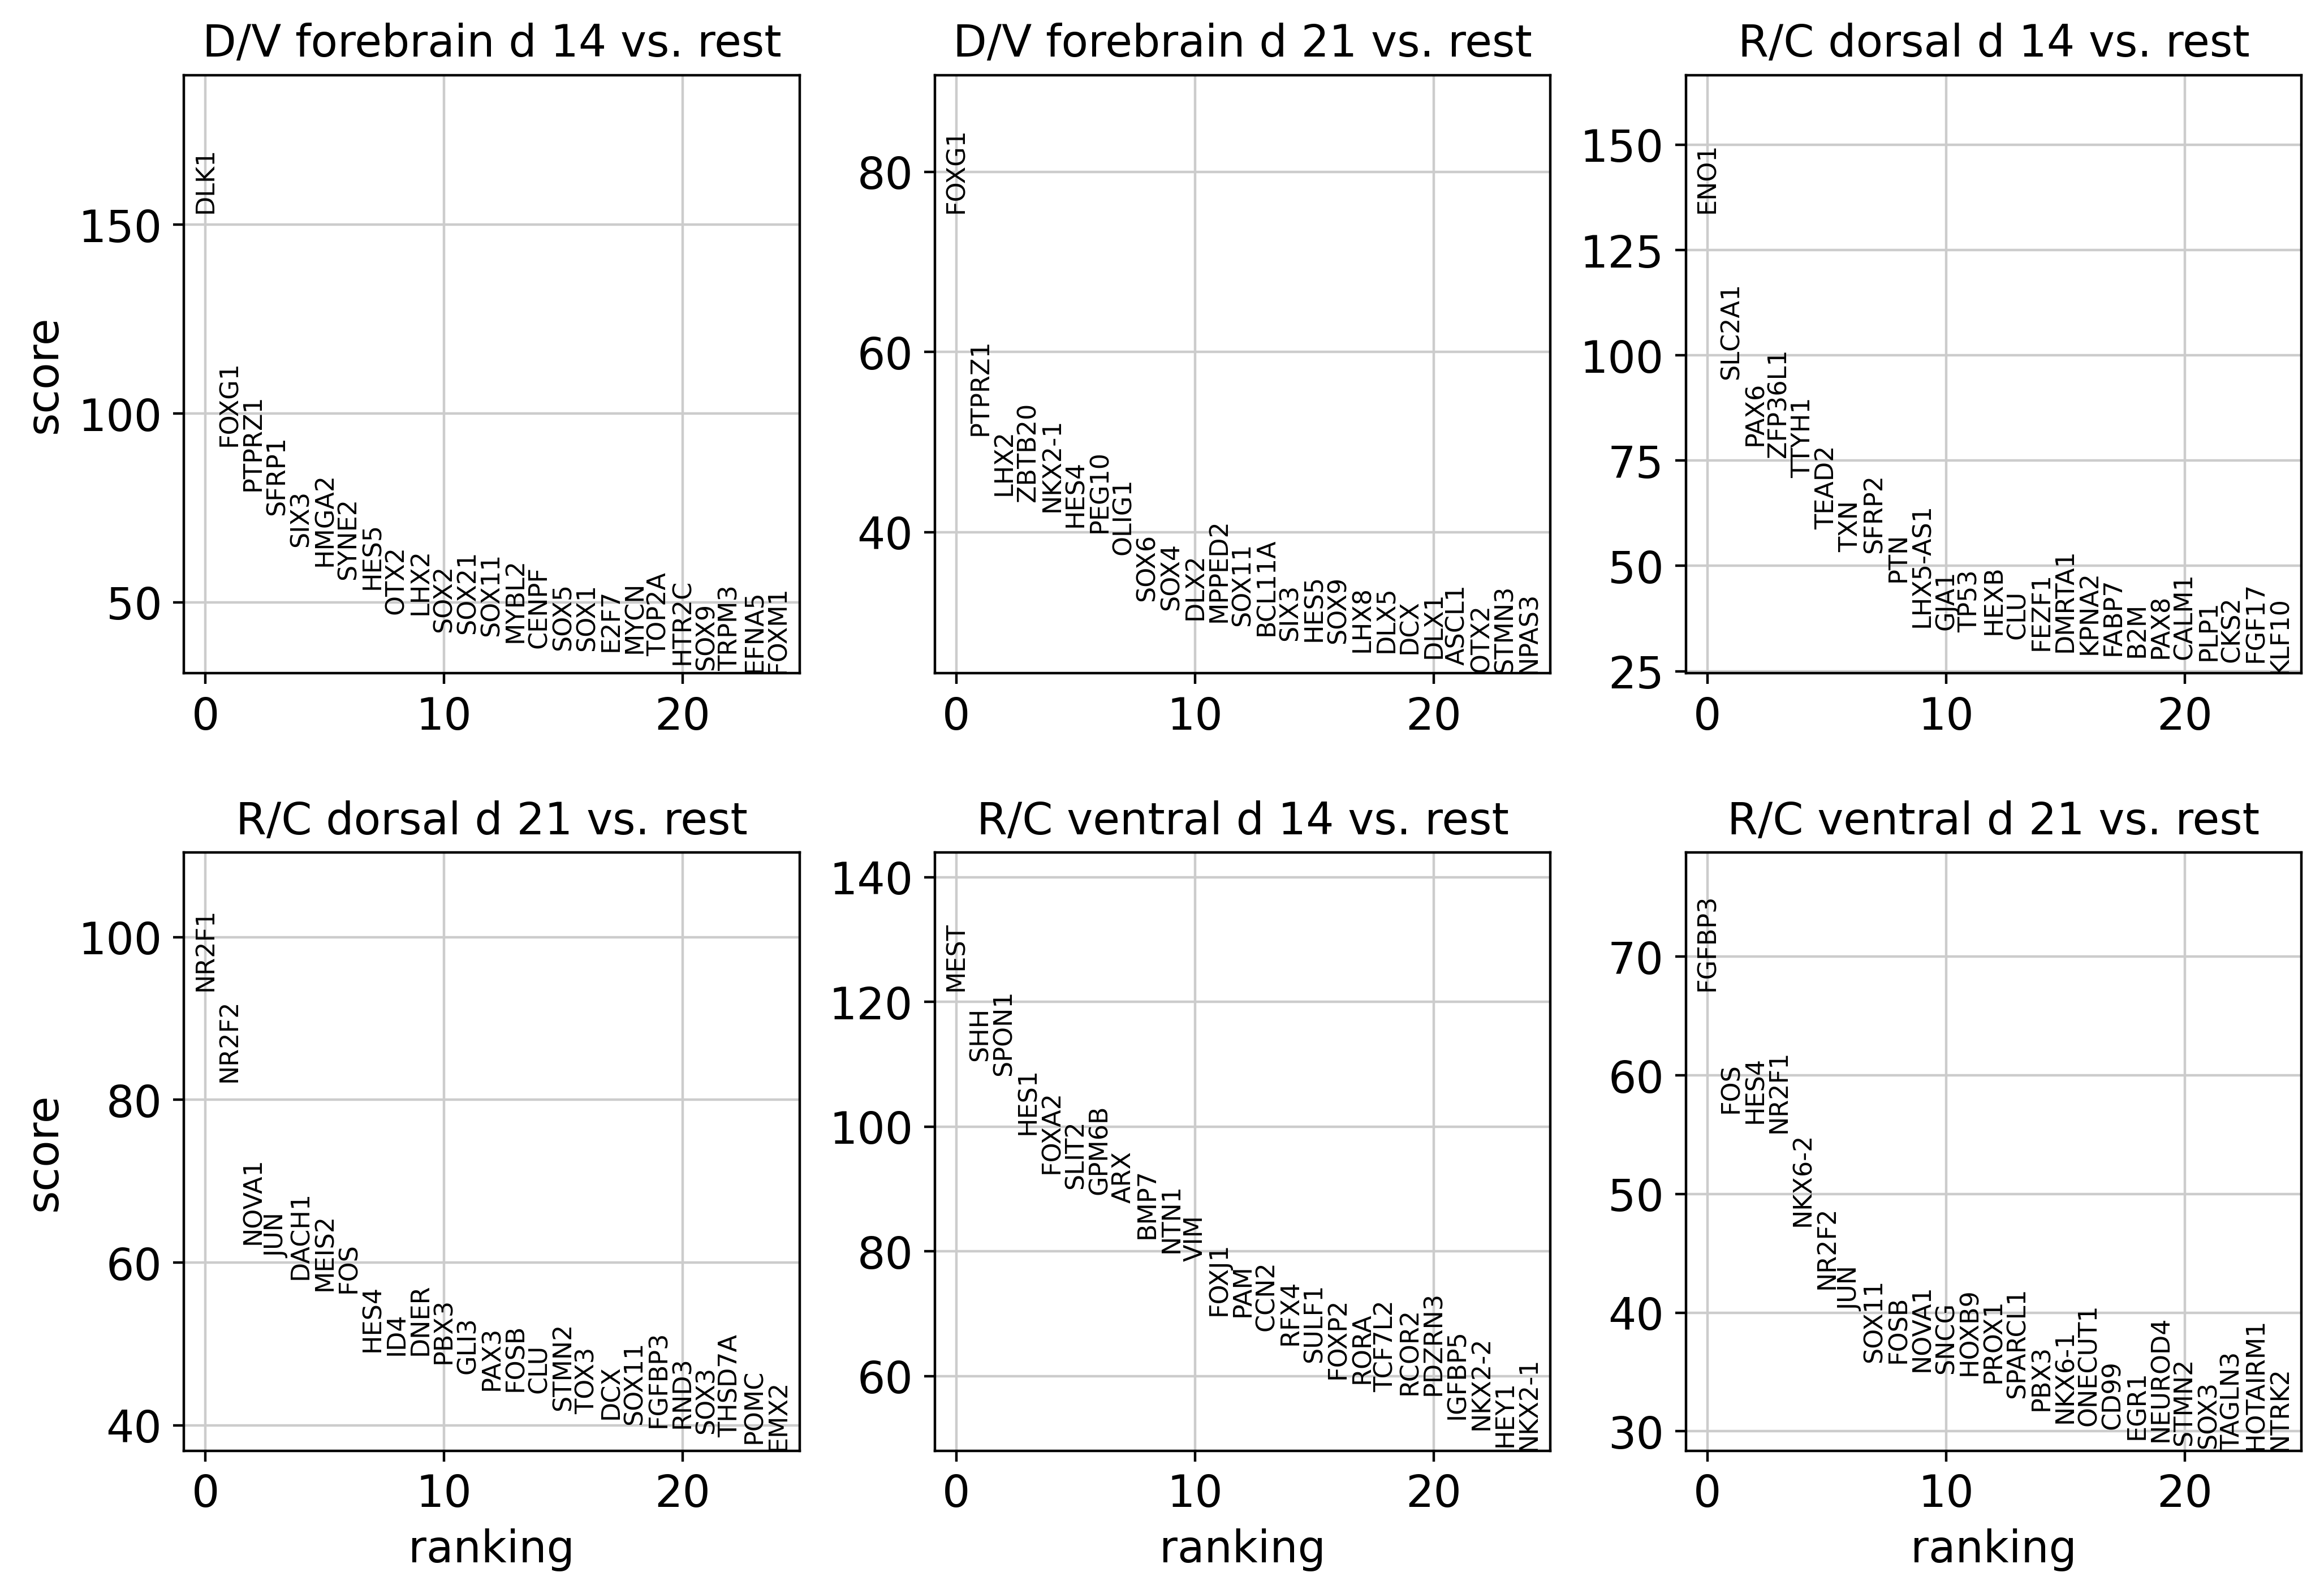

In [7]:
# Plotting DE genes used in bonefight
with plt.rc_context({"figure.figsize": [4, 4],  "figure.dpi": 200}):
    sc.pl.rank_genes_groups(mistr_data_d14_d21_gene_subset, n_genes=25, sharey=False,ncols=3, save="_DE_genes_for_bonefight.svg")

In [8]:
mistr_data_d14_d21_gene_subset_2.obs["tissue"].value_counts()

R/C dorsal d 14       19314
R/C dorsal d 21       15013
R/C ventral d 14      13933
R/C ventral d 21      13249
D/V forebrain d 14     6840
D/V forebrain d 21     6223
Name: tissue, dtype: int64

In [9]:
# Bonefight maps clusters instead of single cells 
# Subsample the data so that all the clusters have equal size
tissue_types = np.unique(mistr_data_d14_d21_gene_subset_2.obs['tissue'])
subsampled = []
for tissue_type in tissue_types:
    subset = mistr_data_d14_d21_gene_subset_2[mistr_data_d14_d21_gene_subset_2.obs['tissue'] == tissue_type, :]
    if len(subset) >= 6223:
        sc.pp.subsample(subset, n_obs=6223)    
    subsampled.append(subset)
    
# Combine subsampled datasets into a single AnnData object
subsampled_adata = subsampled[0].concatenate(subsampled[1:], join='outer')

subsampled_adata

AnnData object with n_obs × n_vars = 37338 × 125
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.4', 'seurat_clusters', 'day', 'model', 'tissue', 'source', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'SCT_snn_res.0.6', 'SCT_snn_res.0.8', 'SCT_snn_res.1', 'SCT_snn_res.1.2', 'nCount_integrated', 'nFeature_integrated', 'ident', 'batch'
    obsm: 'MNN', 'X_umap'
    layers: 'counts', 'logcounts'

In [10]:
# Create cluster gene expression matrix
def create_expression_matrix(adata):
    adata.obs['tissue'] = adata.obs['tissue'].astype('category')
    cluster_expression = pd.DataFrame(columns=adata.var_names, index=adata.obs['tissue'].cat.categories)                                                                                                 

    for clust in subsampled_adata.obs["tissue"].cat.categories: 
        cluster_expression.loc[clust] = adata[adata.obs['tissue'].isin([clust]),:].X.mean(0)
    return cluster_expression.transpose().sort_index()

bonefigt_expression_matrix = create_expression_matrix(subsampled_adata)

# Get value counts to dictionary and sort according the columns in cluster_expression dataframe
cluster_counts_dict = subsampled_adata.obs["tissue"].value_counts().to_dict()
cluster_counts_dict = sorted(cluster_counts_dict.items(), key=lambda pair: list(bonefigt_expression_matrix.columns).index(pair[0]))

# Volume_sc contains the cluster counts
volume_sc = np.array(list(dict(cluster_counts_dict).values()))


In [11]:
bonefigt_expression_matrix

D/V forebrain d 14 D/V forebrain d 21 R/C dorsal d 14 R/C dorsal d 21  \
ARX               0.074241            0.57191        0.128395        0.574803   
ASCL1             0.163587           0.830307        0.087739        0.360437   
B2M               1.020247           0.899566        1.284107        0.920777   
BCL11A            0.004499           0.317371         0.00241        0.165997   
BMP7              0.412341            0.28941        0.122128        0.156195   
...                    ...                ...             ...             ...   
TTYH1             4.762814           4.269643        7.224326        5.950665   
TXN                3.96095           3.392414        3.957575         2.56725   
VIM               8.486654          17.310768       20.851641          29.576   
ZBTB20            0.399807           1.056725        0.192994        0.553431   
ZFP36L1           1.952916           1.787722        4.533021        3.284106   

        R/C ventral d 14 R/C ventral d 21  
ARX             3.267233         0.767797  
ASCL1           0.209224         0.480315  
B2M             0.774224          1.19685  
BCL11A          0.009963         0.062992  
BMP7            1.137072         0.363651  
...                  ...              ...  
TTYH1           2.530129         5.346455  
TXN             2.500883         2.843322  
VIM             43.52721        28.014229  
ZBTB20          0.340029         0.372007  
ZFP36L1         2.241201         3.174673  

[125 rows x 6 columns]

# Bonefight

In [12]:
# Initialize bonefight and train the model
a = bf.View(bonefigt_expression_matrix.T.to_numpy(), volume_sc)
b = bf.View(count_df.to_numpy(), volume_sp)
model = bf.BoneFight(a, b).fit(80, 0.1)


100%|██████████| 80/80 [00:10<00:00,  7.40it/s, loss=-1.2034864]


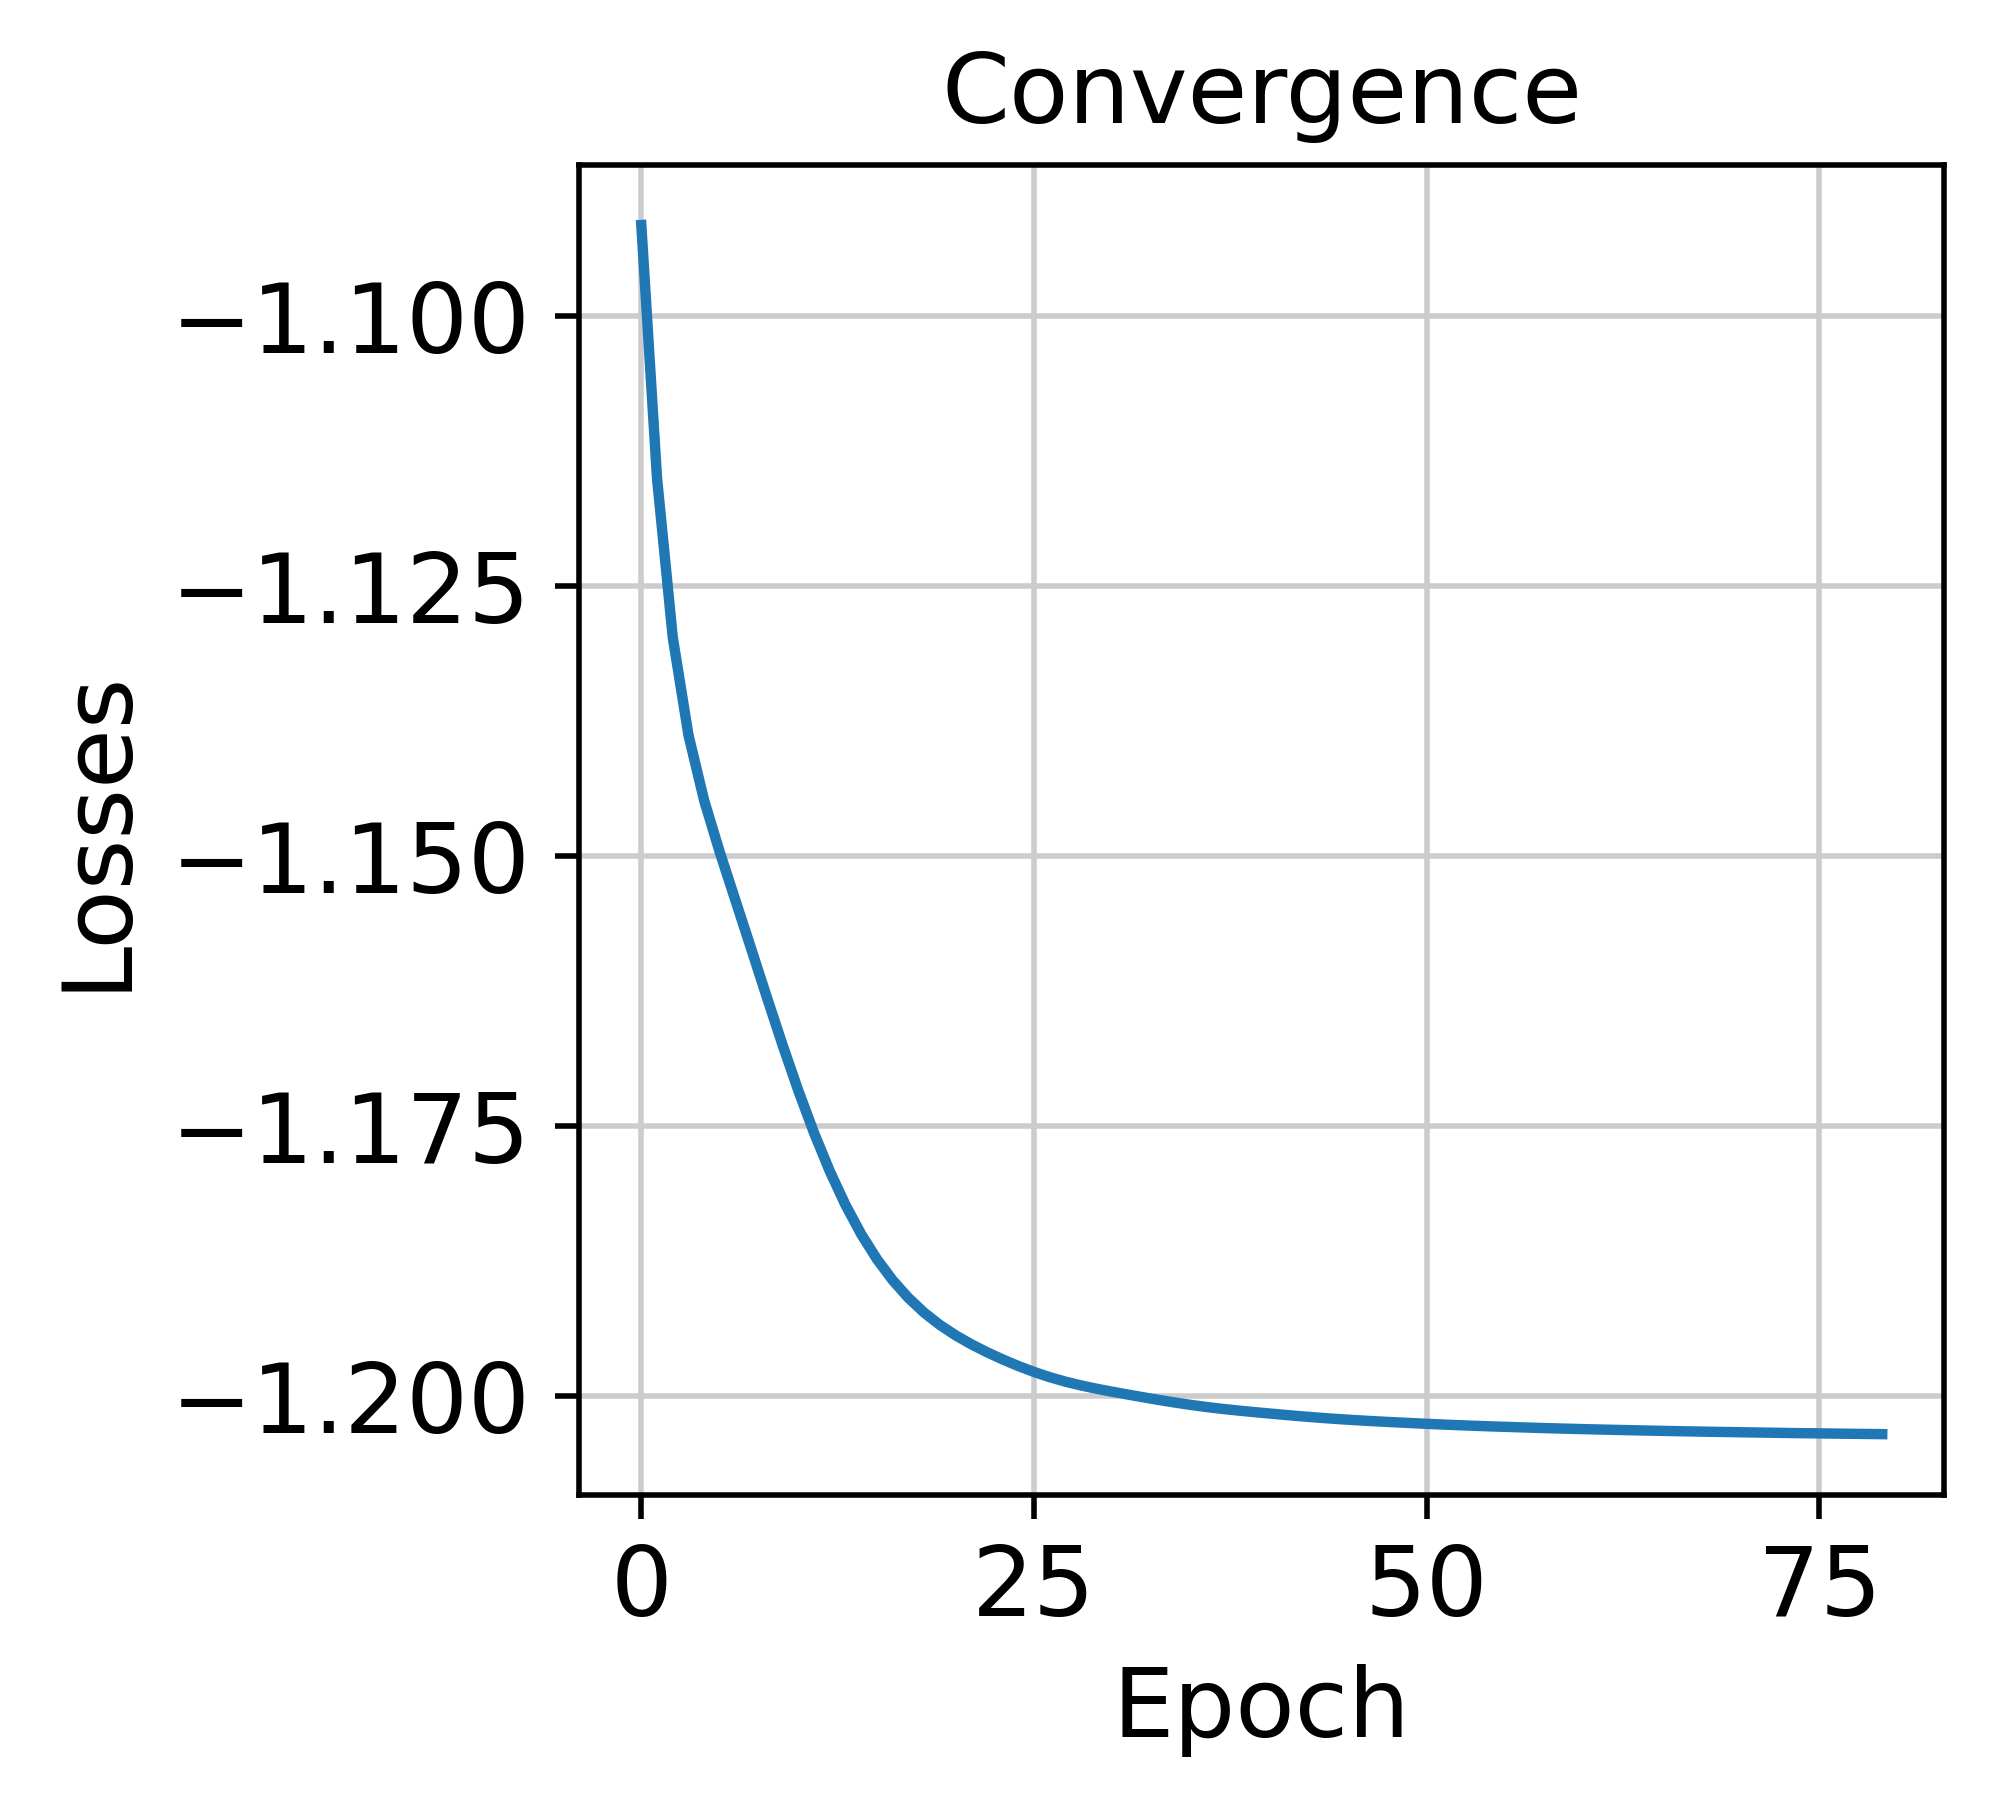

In [13]:
# Plot the training process to see that the model has reached convergence
with plt.rc_context({"figure.figsize": [3.5, 3.5], "figure.dpi": 250}):
    plt.figure()
    plt.plot(model.losses)
    plt.title('Convergence')
    plt.xlabel('Epoch')
    plt.ylabel('Losses')

In [14]:
# Create an identity matrix, shape (n_clusters, n_clusters)
labels = np.eye(len(bonefigt_expression_matrix.columns))
# Transform it, and the result will be (x, y, n_clusters)
y = model.transform(labels)

#Put results in dataframe
bonefight_df = pd.DataFrame(y, index=count_df.index, columns=bonefigt_expression_matrix.columns)

In [15]:
# Smooth results
# This smoothing function is from the first-trimester developing human brain -publication 
# (https://www.biorxiv.org/content/10.1101/2022.10.24.513487v1.full)
def _smooth(xy, data, k=40, weight=True):
    
    k += 1 #It will find itself but this is later removed
    tree = KDTree(xy)
    dist, kneigh = tree.query(xy, k=k)
    data_np = data.to_numpy()
    mean = data_np[kneigh[:, :]]
    
    if weight:
        #Weigh by distance
        dist_max = dist.max()
        mean = mean * (dist_max - dist[:,:, np.newaxis])
        
    mean = mean.mean(axis=1)
    
    return mean

smooth0_5w = _smooth(coordinates_to_keep, bonefight_df)

bonefight_df_smooth = pd.DataFrame(data = smooth0_5w, index = bonefight_df.index, columns=bonefight_df.columns)
bonefight_df_smooth.shape

(1164, 6)

# Prepare bonefight results for tangram functions

In [16]:
# Tangram plotting function inverts the y axis, and there is no parameter to control this
# Therefore this function can be used to invert the y axis before passing the data to tangram plotting functions
# and when tangram inverts the axis again, the plot is displayed correctly

def invert_y_axis_for_tangram(adata):
    counter, inverted_coordinates = 0, []
    # Looping over the coordinatas, and multiplying the y-axis coordinates by 1 and append the updated coordinates to list
    for i in range(len(adata.obsm["spatial"])):
        inverted_coordinates.append((adata.obsm["spatial"][i][0],adata.obsm["spatial"][i][1]*-1))

    # Store the updated coordinates in adata_spatial object
    adata.obsm["spatial"] = np.array(inverted_coordinates)
    return adata

In [17]:
# Calling the function that invers y axis, both with the full and subsetted spatial data
adata_spatial = invert_y_axis_for_tangram(adata_spatial)
adata_spatial_full = invert_y_axis_for_tangram(adata_spatial_full)
adata_spatial.obsm["spatial"]

array([[-1813.24873063, -2828.79143365],
       [-1838.24873063, -2872.09270384],
       [-1888.24873063, -2872.09270384],
       ...,
       [-4663.24873063, -6206.29050841],
       [-4713.24873063, -6206.29050841],
       [-4763.24873063, -6206.29050841]])

In [18]:
# This code is edited version of tangrams plot_cell_annotation_sc function
# The original function contained some shortcommings, therefore this custom version is used
# Only small edits was made: allows saving the figure and some additional parameters
import pylab as pl
sc.set_figure_params(scanpy=True, fontsize=10)
def construct_obs_plot(df_plot, adata, perc=0, suffix=None):
    # clip
    df_plot = df_plot.clip(df_plot.quantile(perc), df_plot.quantile(1 - perc), axis=1)

    # normalize
    df_plot = (df_plot - df_plot.min()) / (df_plot.max() - df_plot.min())

    if suffix:
        df_plot = df_plot.add_suffix(" ({})".format(suffix))
    adata.obs = pd.concat([adata.obs, df_plot], axis=1)

def plot_cell_annotation_custom(adata_sp, annotation_list, x="x", y="y", spot_size=None, scale_factor=None, perc=0,alpha_img=1.0,bw=False,ax=None, show=True, save=False, ncols=4):
    # 'Spectral_r'
    # remove previous df_plot in obs
    adata_sp.obs.drop(annotation_list, inplace=True, errors="ignore", axis=1)

    # construct df_plot
    df = adata_sp.obsm["tangram_ct_pred"][annotation_list]
    construct_obs_plot(df, adata_sp, perc=perc)
    
    #non visium data 
    if 'spatial' not in adata_sp.obsm.keys():
        #add spatial coordinates to obsm of spatial data 
        coords = [[x,y] for x,y in zip(adata_sp.obs[x].values,adata_sp.obs[y].values)]
        adata_sp.obsm['spatial'] = np.array(coords)
    
    if 'spatial' not in adata_sp.uns.keys() and spot_size == None and scale_factor == None:
        raise ValueError("Spot Size and Scale Factor cannot be None when ad_sp.uns['spatial'] does not exist")
    
    #REVIEW
    if 'spatial' in adata_sp.uns.keys() and spot_size != None and scale_factor != None:
        raise ValueError("Spot Size and Scale Factor should be None when ad_sp.uns['spatial'] exists")
    
    sc.pl.spatial(
        adata_sp, color=annotation_list, cmap="Spectral_r", show=show, frameon=False, spot_size=spot_size,
        scale_factor=scale_factor, alpha_img=alpha_img, bw=bw, ax=ax, ncols=ncols, save=save, colorbar_loc=None)


    adata_sp.obs.drop(annotation_list, inplace=True, errors="ignore", axis=1)

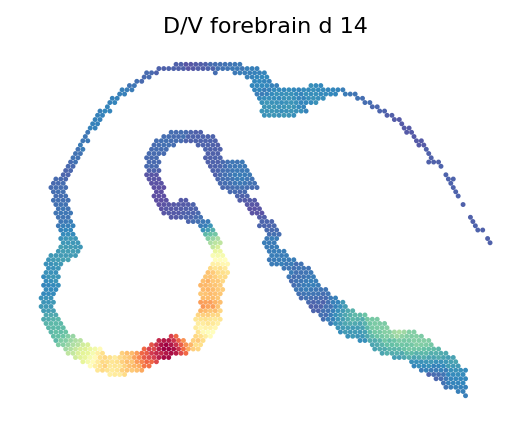

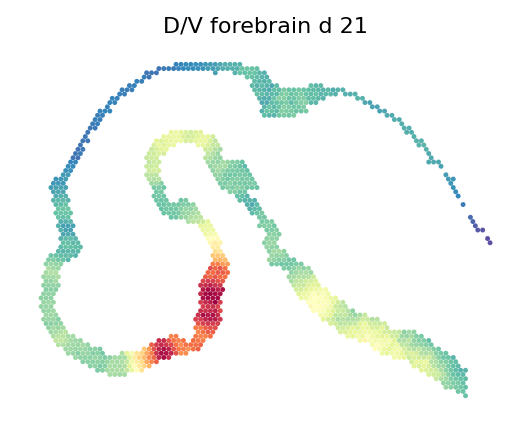

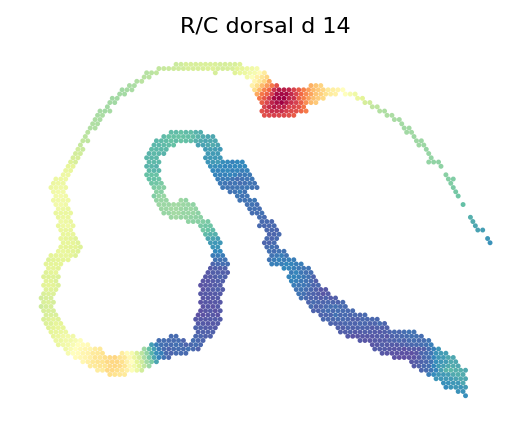

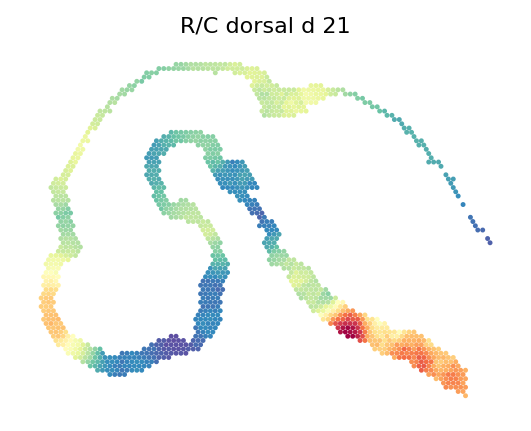

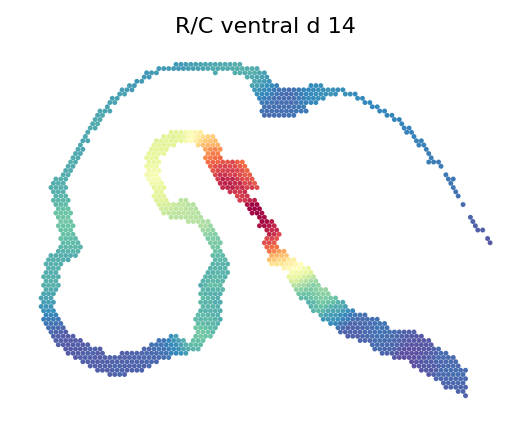

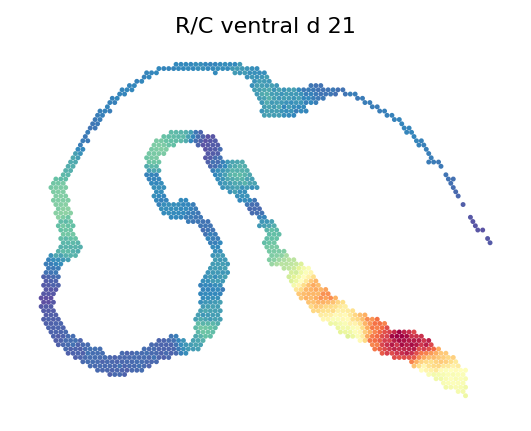

In [19]:
# In tangram tutorial they use project_cell_annotations function to move cell annotations onto space
# However, as the output of project_cell_annotations function corresponds the bonefight's output dataframe,
# we are not running the function in here
# Storing smoothed bonefight output dataframe to adata_spatial and plot the tissue probabilities in space


#Change the coloring

adata_spatial.obsm["tangram_ct_pred"] = bonefight_df_smooth
annotation_list = list(pd.unique(subsampled_adata.obs['tissue']))
adata_spatial.obsm["tangram_adjusted"] = adata_spatial.obsm["tangram_ct_pred"]
annotation_list
for tissue in annotation_list:
    plot_cell_annotation_custom(adata_spatial, [tissue],x="x",y="y", spot_size=50, scale_factor=0.1, perc=0.001, ncols=3, save="_tissue_probability_svg/"+tissue[3:]+"_probabilities.svg", show=True)   
    plot_cell_annotation_custom(adata_spatial, [tissue],x="x",y="y", spot_size=50, scale_factor=0.1, perc=0.001, ncols=3, save="_tissue_probability_png/"+tissue[3:]+"_probabilities.png", show=False)   
    
    
# These plots shows the probability of spot j to belong to tissue i
#plot_cell_annotation_custom(adata_spatial, annotation_list,x="x",y="y", spot_size=50, scale_factor=0.1, perc=0.001, ncols=3, save="_tissue_probabilities.svg", show=True)

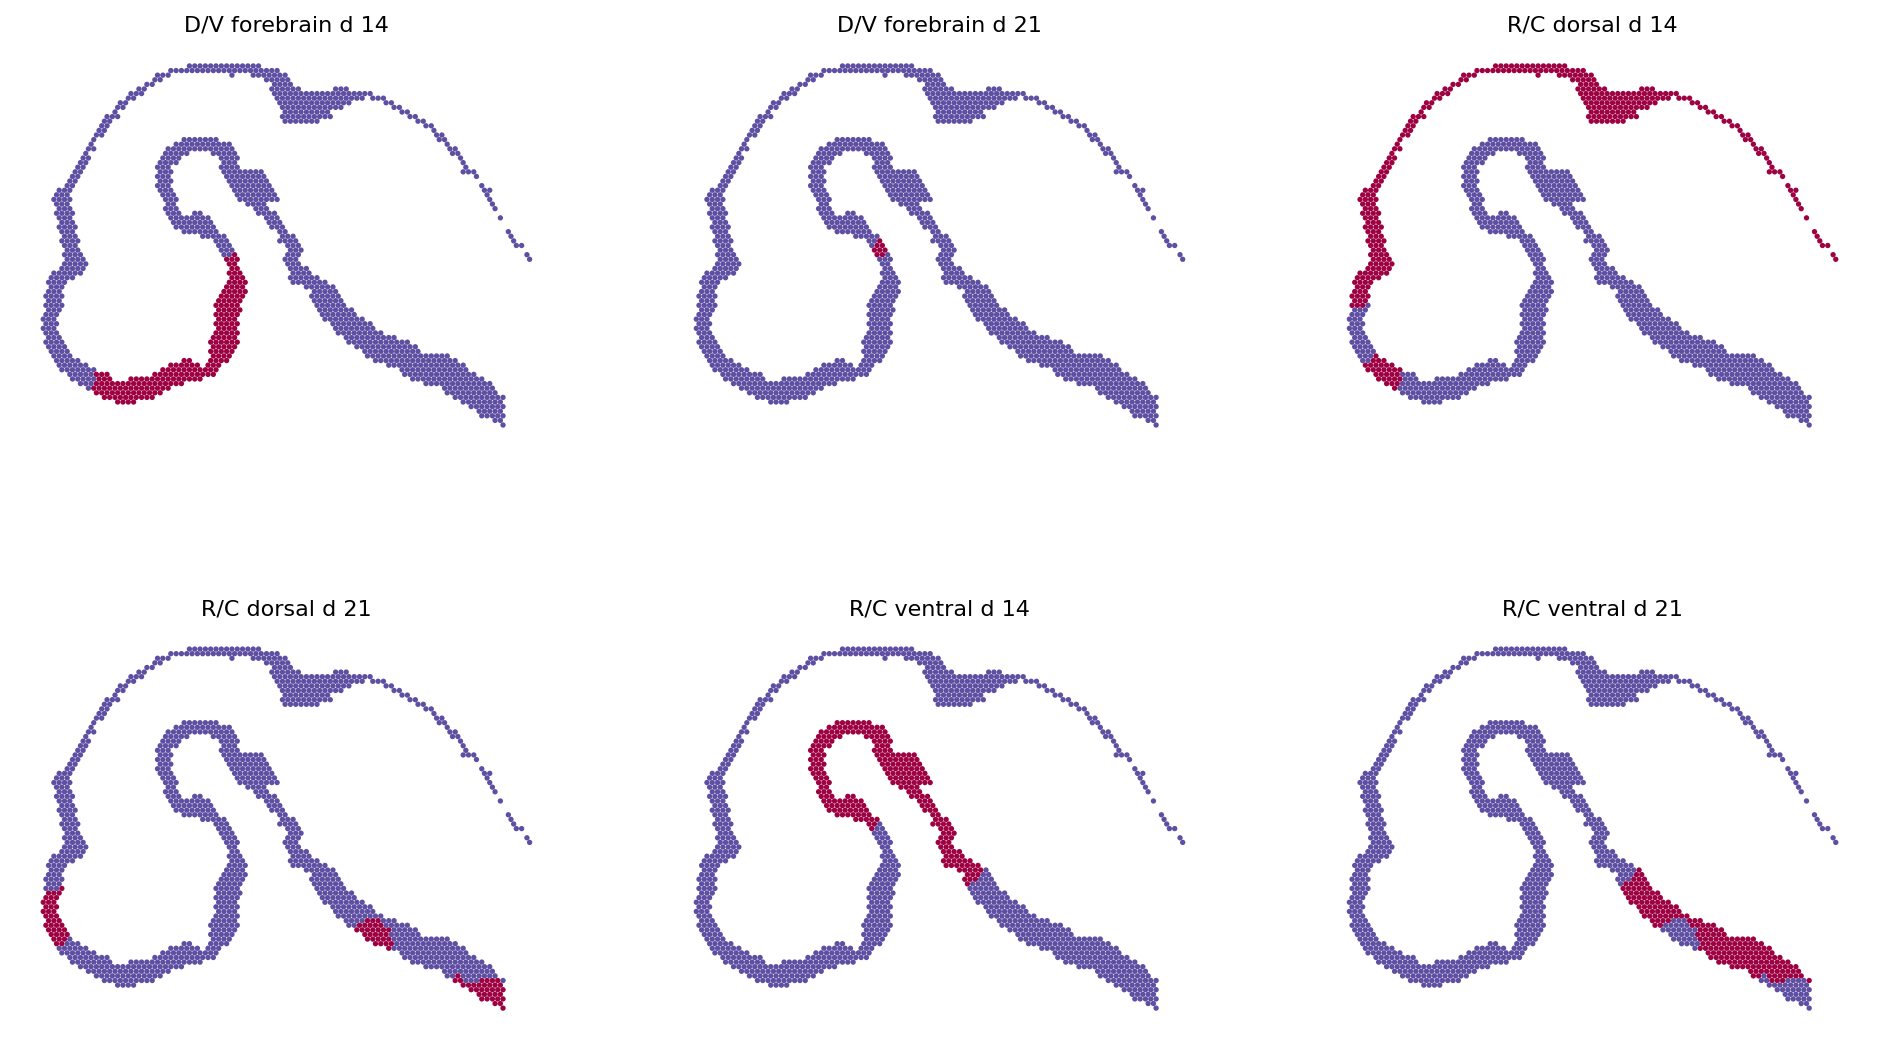

In [20]:
# The tissue with highest probability value is assigned for each spatial spot
# The tissue with highest probability gets value 1, rest gets value 0

adata_spatial.obsm["tangram_adjusted"] = adata_spatial.obsm["tangram_adjusted"].eq(adata_spatial.obsm["tangram_adjusted"].where(adata_spatial.obsm["tangram_adjusted"] != 0).max(1), axis=0).astype(int)
adata_spatial.obsm["tangram_ct_pred"] = adata_spatial.obsm["tangram_adjusted"]
# Plot the assigned tissues on space
plot_cell_annotation_custom(adata_spatial, annotation_list,x='x', y='y',spot_size= 50, scale_factor=0.1, perc=0.001, ncols=3, save="_assigned_tissue.svg", show=True)


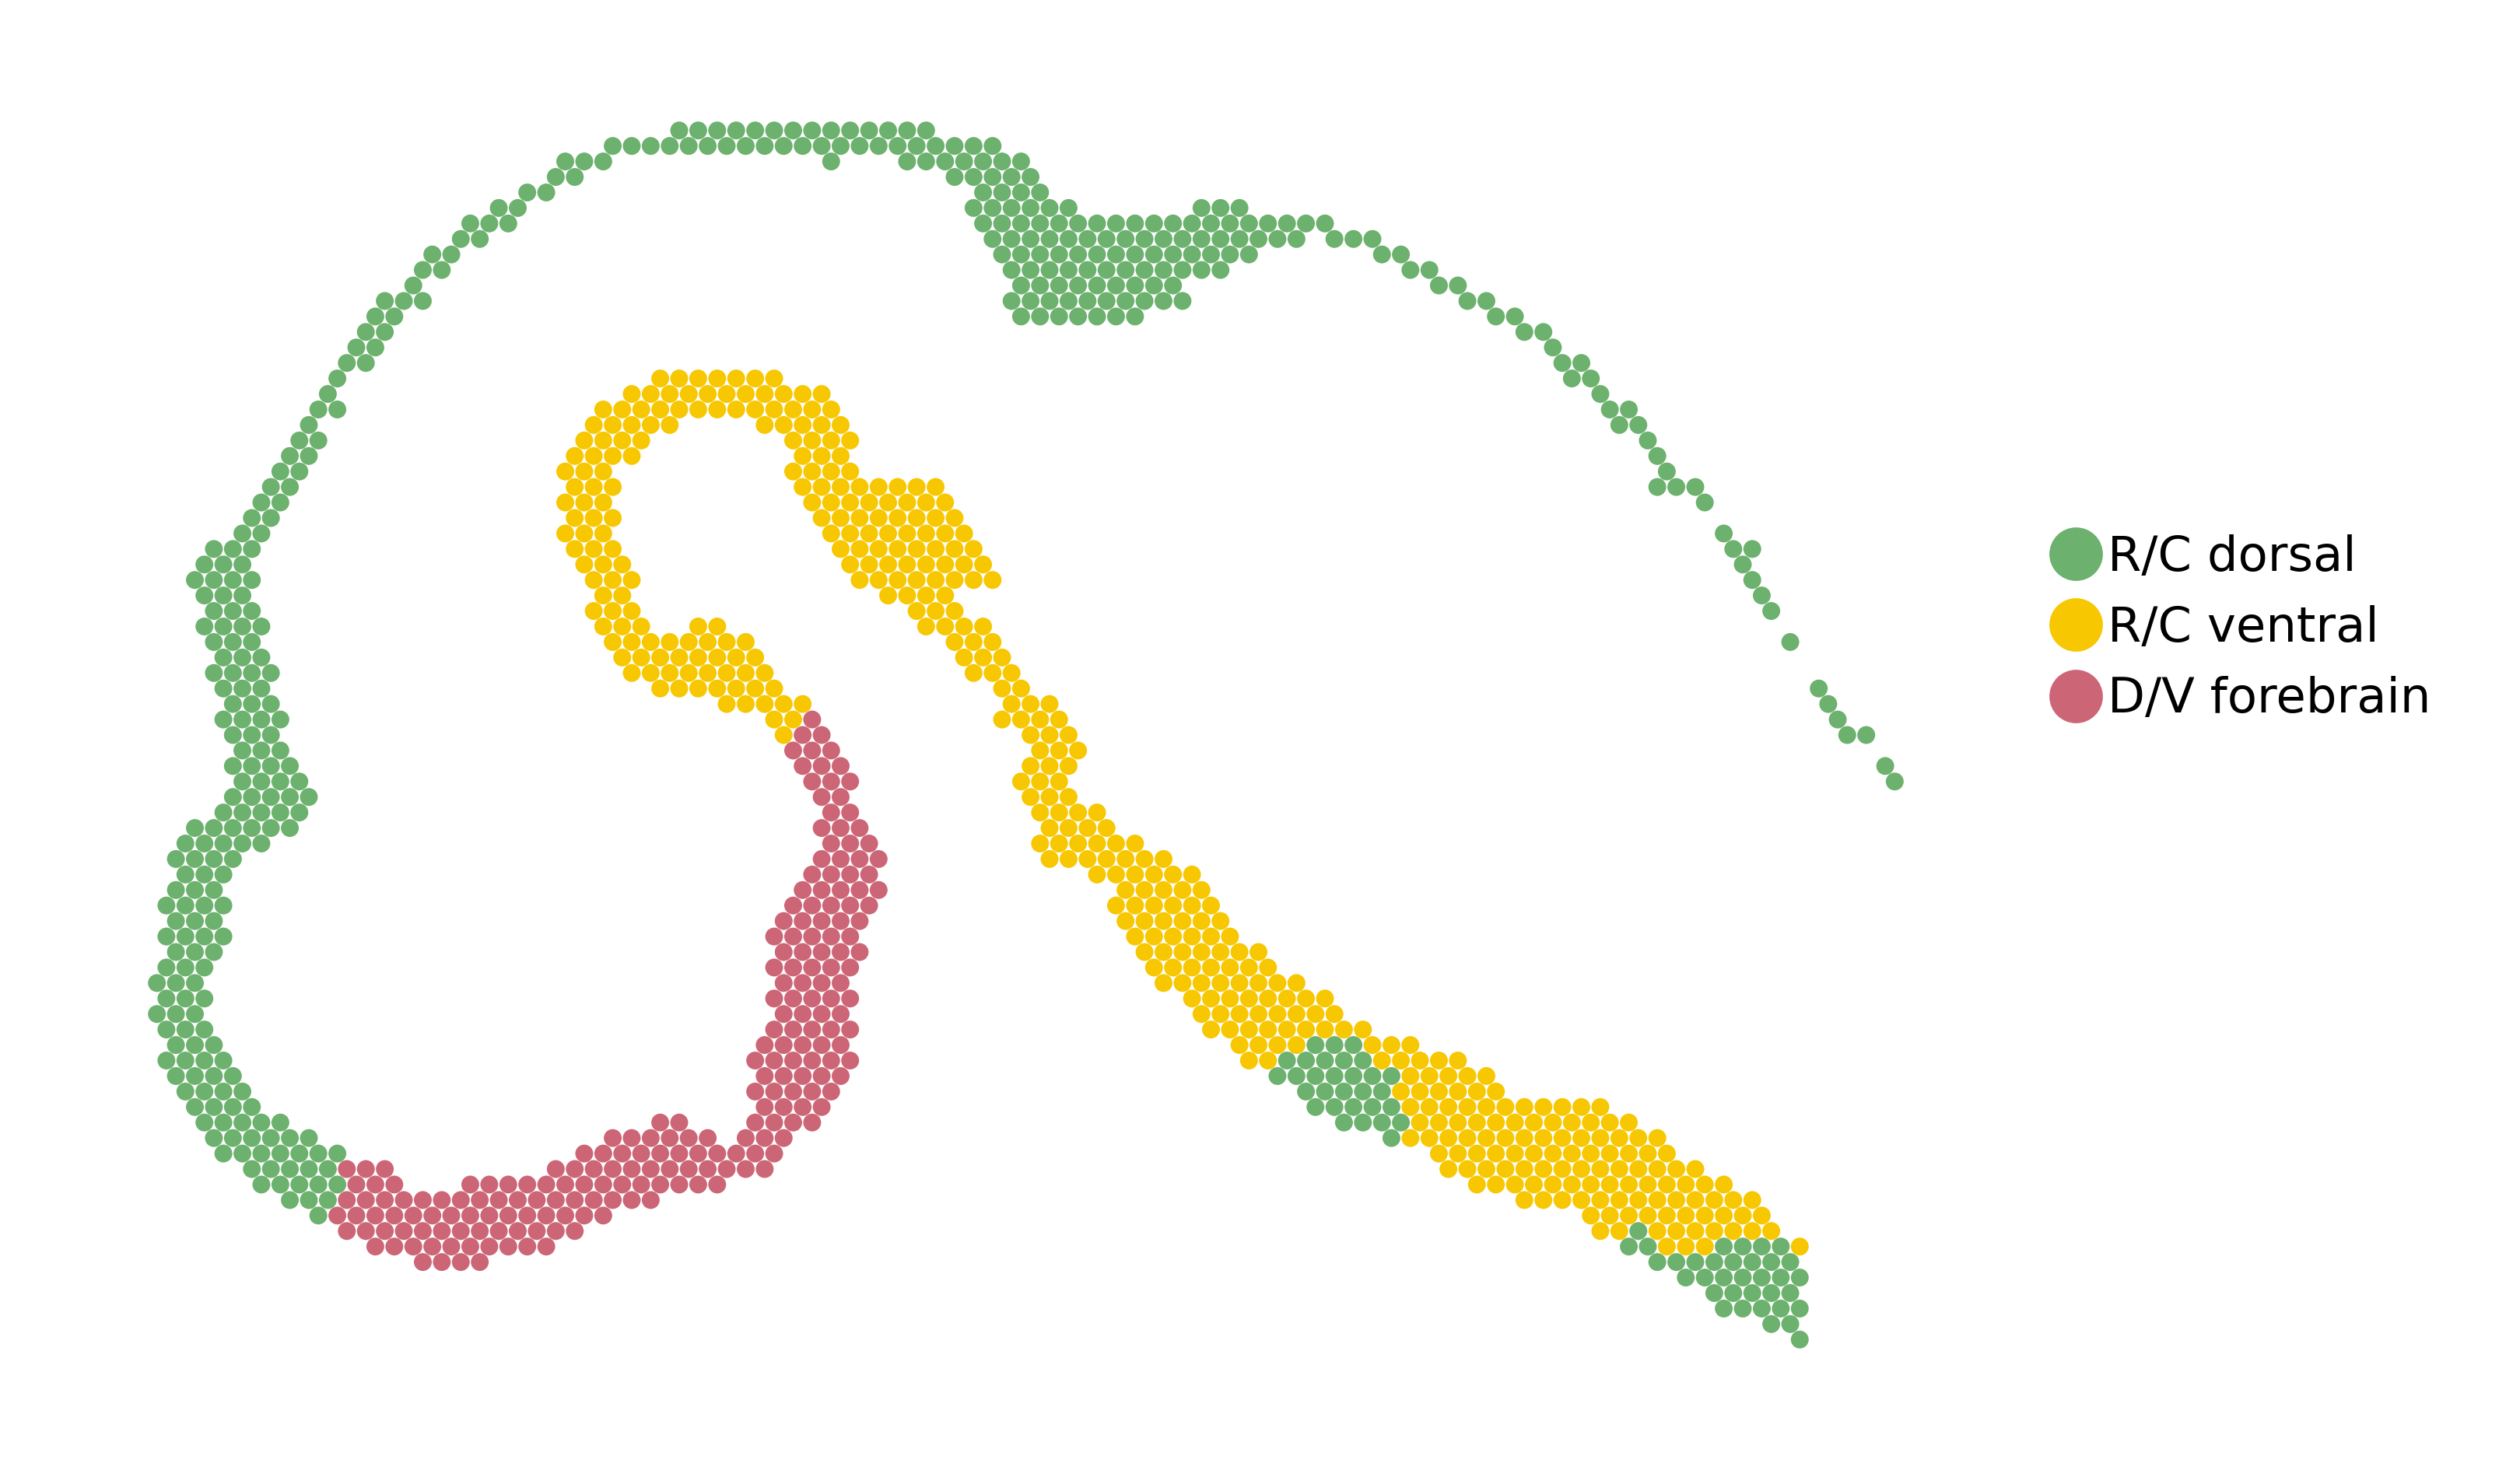

In [21]:
# Next we merge d14 and d21 clusters so that we have one cluster for each tissue

# Merging the clusters 
adata_spatial.obs["predicted_tissue"] = list(adata_spatial.obsm["tangram_adjusted"].idxmax(axis=1).values)
adata_spatial.obs['merged_pred_tissue'] = adata_spatial.obs['predicted_tissue'].replace({'R/C dorsal d 21': 'R/C dorsal', 'R/C dorsal d 14': 'R/C dorsal', 
                                'R/C ventral d 14': 'R/C ventral', 'R/C ventral d 21': 'R/C ventral',
                                'D/V forebrain d 14': 'D/V forebrain', 'D/V forebrain d 21':'D/V forebrain'})

# Color code the clusters
adata_spatial.obs["tissue_color"] = "unknown"
adata_spatial.obs.loc[adata_spatial.obs['merged_pred_tissue'] == 'R/C dorsal', 'tissue_color'] = "#6cb16d"
adata_spatial.obs.loc[adata_spatial.obs['merged_pred_tissue'] == 'R/C ventral', 'tissue_color'] = "#f7c701"
adata_spatial.obs.loc[adata_spatial.obs['merged_pred_tissue'] == 'D/V forebrain', 'tissue_color'] = "#cc6677"
import matplotlib.lines as mlines
# Plotting results
with plt.rc_context({"figure.figsize": [3.5, 2.5],  "figure.dpi": 450}):
    xs = adata_spatial.obs.x.values
    ys = adata_spatial.obs.y.values
    plt.scatter(xs, ys, s=0.7, c=adata_spatial.obs['tissue_color'].values);
    plt.axis('off')
    dorsal_legend = mlines.Line2D([],[],color='#6cb16d', label='R/C dorsal', marker="o", markersize=4.5)
    ventral_legend = mlines.Line2D([],[],color='#f7c701', label='R/C ventral', marker="o", markersize=4.5)
    forebrain_legend = mlines.Line2D([],[],color='#cc6677', label='D/V forebrain', marker="o", markersize=4.5)
    plt.legend(handles=[dorsal_legend,ventral_legend,forebrain_legend ], loc="center left",  bbox_to_anchor=(1.02, 0.58), frameon=False, prop={'size': 5})
    plt.grid()
    plt.savefig('figures/projected_tissues.svg', dpi=450, bbox_inches='tight')
    pl.savefig("figures/projected_tissues.png", dpi=450, bbox_inches='tight')  
    plt.show()

# Projecting all genes from MiSTR data to space

In [22]:
mistr_data_d14_d21

AnnData object with n_obs × n_vars = 74572 × 31522
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.4', 'seurat_clusters', 'day', 'model', 'tissue', 'source', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'SCT_snn_res.0.6', 'SCT_snn_res.0.8', 'SCT_snn_res.1', 'SCT_snn_res.1.2', 'nCount_integrated', 'nFeature_integrated', 'ident'
    uns: 'tissue_colors'
    obsm: 'MNN', 'X_umap'
    layers: 'counts', 'logcounts'

In [23]:
# Calling function that creates cluster expression matrix and then convert the matrix to adata, which is the format needed in
# tangram functions
cluster_expression_hvg = create_expression_matrix(mistr_data_d14_d21)
adata_clusters = sc.AnnData(cluster_expression_hvg.T)
cluster_expression_hvg

D/V forebrain d 14 D/V forebrain d 21 R/C dorsal d 14  \
A1BG               0.309502           0.466816        0.169256   
A1BG-AS1           0.026316           0.029728        0.029357   
A1CF               0.001754           0.001446        0.000259   
A2M                 0.00424           0.008517        0.000362   
A2M-AS1            0.058626           0.064278        0.053277   
...                     ...                ...             ...   
ZXDC                0.08421            0.06492         0.01719   
ZYG11A             0.001608           0.000964        0.001243   
ZYG11B             0.398249           0.363812        0.142434   
ZYX                0.176313           0.142375        0.230615   
ZZEF1              0.081432           0.078901        0.027079   

         R/C dorsal d 21 R/C ventral d 14 R/C ventral d 21  
A1BG            0.396253         0.271735         0.589635  
A1BG-AS1        0.025445          0.04414         0.027398  
A1CF            0.001532         0.000789         0.001283  
A2M             0.008326         0.003086          0.00634  
A2M-AS1         0.059415         0.097825         0.058042  
...                  ...              ...              ...  
ZXDC            0.066542         0.134357         0.057439  
ZYG11A          0.001199          0.00201         0.002642  
ZYG11B            0.3427         0.321111         0.334895  
ZYX             0.181175         0.307117         0.239409  
ZZEF1           0.107373         0.084762         0.096158  

[31522 rows x 6 columns]

In [24]:
# Prepare data for project_genes function
# The function takes adata_projected that contains the cluster probabilities, and adata_clusters which was created above
adata_projected = AnnData(bonefight_df_smooth.T)
adata_projected.obs["tissue"] = bonefight_df_smooth.T.index
adata_projected.uns["train_genes_df"] = pd.DataFrame(index=count_df.columns)

# Run project_genes function
ad_ge = tg.project_genes(adata_projected, adata_clusters)
ad_ge.obsm["spatial"] = adata_spatial.obsm["spatial"] # Store spatial coordiantes to adata containing projected genes

In [25]:
ad_ge.X.shape

(1164, 31166)

In [26]:
# By default tangram works with lowercase feature names -> convert feature names to upper case
ad_ge.var.index = ad_ge.var.index.map(str.upper)
adata_spatial.var.index = adata_spatial.var.index.map(str.upper)
adata_spatial_full.var.index = adata_spatial_full.var.index.map(str.upper)

# Visualizing measured and projected gene expression

In [27]:
# This code is edited version of tangram plot_genes_sc function
# The original function contained some shortcommings,
# and therefore a customized version of it was used to plot mesured / projected genes on space
# The original function allows plotting measured and projected expression side by side,
# whereas this function plots either measured or projected genes
# Other changes: possibility to save the figure and some additional parameters that serves better our purposes

from scipy.sparse.csr import csr_matrix
from scipy.sparse.csc import csc_matrix
from matplotlib.gridspec import GridSpec
sc.set_figure_params(dpi_save = 500)


def convert_adata_array(adata):
    if isinstance(adata.X, csc_matrix) or isinstance(adata.X, csr_matrix):
        adata.X = adata.X.toarray()
        
def tangram_plot_genes_custom(adata, genes=[], x="x",y = "y",spot_size=None, save=False,scale_factor=None, ncols=4, cmap="inferno",
                              perc=0,alpha_img=1.0,bw=False,return_figure=False, plot_measured_spatial=False, show=True):
    # construct df_plot
    data = []
    
    # remove df_plot in obs
    if plot_measured_spatial == False:
        adata.obs.drop(["{} (projected gene expression)".format(gene) for gene in genes], inplace=True, errors="ignore", axis=1)
        adata.var.index = [g.upper() for g in adata.var.index]
        adata.obs.drop(["{} (projected gene expression)".format(gene) for gene in genes], inplace=True, errors="ignore", axis=1)
        
        df = pd.DataFrame(data=np.array(adata[:, genes].X), columns=genes, index=adata.obs.index)
        construct_obs_plot(df, adata, perc=perc, suffix="projected gene expression")
            
    else:
        adata.obs.drop(["{} (measured gene expression)".format(gene) for gene in genes], inplace=True, errors="ignore", axis=1)
        
        # prepare adatas
        convert_adata_array(adata)
        adata.var.index = [g.upper() for g in adata.var.index]
        adata.obs.drop(["{} (measured gene expression)".format(gene) for gene in genes],inplace=True,errors="ignore",axis=1,)
        for ix, gene in enumerate(genes):
            if gene not in adata.var.index:
                data.append(np.zeros_like(np.array(adata[:, 0].X).flatten()))
            else:
                data.append(np.array(adata[:, gene].X).flatten())

        df = pd.DataFrame(
            data=np.array(data).T, columns=genes, index=adata.obs.index,
        )
        construct_obs_plot(df, adata, suffix="measured gene expression")

    fig = plt.figure(figsize=(7, len(genes) * 3.5))
    gs = GridSpec(len(genes), 2, figure=fig)
    
    #non visium data
    if 'spatial' not in adata.obsm.keys():
        #add spatial coordinates to obsm of spatial data 
        if plot_measured_spatial == True:
            coords = [[x,y] for x,y in zip(adata.obs[x].values,adata.obs[y].values)]
            adata.obsm['spatial'] = np.array(coords)
        else:
            coords = [[x,y] for x,y in zip(adata.obs[x].values,adata.obs[y].values)]
            adata.obsm['spatial'] = np.array(coords)

    if ("spatial" not in adata.uns.keys()) and (spot_size==None and scale_factor==None):
        raise ValueError("Spot Size and Scale Factor cannot be None when ad_sp.uns['spatial'] does not exist")
        
    gene_list=[]
    for gene in genes:
        if plot_measured_spatial==True:       
            gene_list.append("{} (measured gene expression)".format(gene))          
        else:
            gene_list.append("{} (projected gene expression)".format(gene))
        
    if plot_measured_spatial == True:
        sc.pl.spatial(adata, spot_size=spot_size, scale_factor=scale_factor, color=gene_list,
            frameon=False, show=show, cmap=cmap, alpha_img=alpha_img, bw=bw, ncols=ncols, colorbar_loc=None, save=save)
    else: 
        #key = dict_keys[i+j]
        #sc.pl.spatial(adata, spot_size=spot_size, scale_factor=scale_factor, color=["{} (predicted)".format(gene)],
        sc.pl.spatial(adata, spot_size=spot_size, scale_factor=scale_factor, color=gene_list, 
            frameon=False, show=show, cmap=cmap, alpha_img=alpha_img, bw=bw, ncols=ncols, colorbar_loc=None,save=save )
    
    if show == True:
        a = np.array([[0,1]])
        pl.figure(figsize=(0.14, 4.5))
        img = pl.imshow(a, cmap="Spectral_r")
        pl.gca().set_visible(False)
        cax = pl.axes([0.1, 0.2, 0.8, 0.6])
        pl.colorbar(orientation="vertical", cax=cax)
        pl.savefig("figures/Spectral_r_colorbar.png", dpi=450, bbox_inches='tight')

        a = np.array([[0,1]])
        pl.figure(figsize=(0.14, 1.8))
        img = pl.imshow(a, cmap="Spectral_r")
        pl.gca().set_visible(False)
        cax = pl.axes([0.1, 0.2, 0.8, 0.6])
        pl.colorbar(orientation="vertical", cax=cax)
        pl.savefig("figures/Spectral_r_colrobar.png", dpi=450, bbox_inches='tight')
    
    # remove df_plot in obs
    if plot_measured_spatial == True:
        adata.obs.drop(["{} (measured gene expression)".format(gene) for gene in genes], inplace=True, errors="ignore", axis=1)
    else:
        adata.obs.drop(["{} (projected gene expression)".format(gene) for gene in genes], inplace=True, errors="ignore", axis=1)
          
    if return_figure==True:
        return fig

In [28]:
for gene in ["BARHL1", "DLX2","COL1A1", "EN1", "FGF17","FOXA2", "HOXB7", "LMX1A", "HES1", "GBX2", "OTX2", "FOXG1", "HOXB1", "HOXB2", "HOXB7"]:
    tangram_plot_genes_custom(ad_ge, genes=[gene], 
                        spot_size=50, scale_factor=0.1, perc = 0.001, return_figure=False, cmap="Spectral_r", plot_measured_spatial=False, ncols=4,
                          save="_projected_png/_"+gene+"_projected_expression.png", show=False)
    
    tangram_plot_genes_custom(adata_spatial_full, genes=[gene],spot_size=50,
                          scale_factor=0.1, perc = 0.001, return_figure=False, cmap="Spectral_r", plot_measured_spatial=True, save="_measured_png/_"+gene+"_measured_expression.png", show=False)
    
    tangram_plot_genes_custom(ad_ge, genes=[gene], 
                        spot_size=50, scale_factor=0.1, perc = 0.001, return_figure=False, cmap="Spectral_r", plot_measured_spatial=False, ncols=4,
                          save="_projected_svg/_"+gene+"_projected_expression.svg", show=False)
    
    tangram_plot_genes_custom(adata_spatial_full, genes=[gene],spot_size=50,
                          scale_factor=0.1, perc = 0.001, return_figure=False, cmap="Spectral_r", plot_measured_spatial=True, save="_measured_svg/_"+gene+"_measured_expression.svg", show=False)
    

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>

<Figure size 560x280 with 0 Axes>